In [15]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
data_raw = pd.read_csv("FBRef2020-21.csv")

In [3]:
data_proc = (data_raw.query("Min >= 500")
             .drop(columns = [column for column in data_raw.columns if data_raw[column].isna().sum() > 100]))

display(data_proc[data_proc.isna().sum(axis=1) != 0])

display(data_proc.loc[313].isna().sum())
display(data_proc.loc[1190].isna().sum())
display(data_proc.loc[2525].isna().sum())
display(data_proc.loc[2525].isna().sort_values())


data_proc = data_proc.drop(index=[313,1190,2525]).reset_index()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
313,Salvador Ferrer,es ESP,DF,Spezia,it Serie A,22.0,1998.0,18,14,1190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1190,Jota,pt POR,FW,Valladolid,es La Liga,21.0,1999.0,17,7,668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2525,Martín Zubimendi,es ESP,MF,Real Sociedad,es La Liga,21.0,1999.0,31,17,1882,...,131.4,4.74,1.44,0.05,0.33,0.72,43.9,42.5,96.8,0.86


95

95

2

Player                 False
Att 3rdPress/90        False
Mid 3rdPress/90        False
Def 3rdPress/90        False
SuccPress/90           False
                       ...  
MedAtt/90              False
FKPassAtt/90           False
ProgPassReceived/90    False
ErrToShot/90            True
Clearances/90           True
Name: 2525, Length: 119, dtype: bool

In [4]:
data_num = data_proc.drop(columns = [col for col in data_proc.columns if data_proc[col].dtype not in ['float64','int64']])
data_num = data_num.drop(columns = data_num.columns.tolist()[:data_num.columns.tolist().index('Ast/90')])

## Clustering

6. Nuestro primer objetivo es realizar alg´un agrupamiento de jugadores con caracter´ısticas similares.

(a) Seleccionar dos variables cualesquiera de los datos y realizar un gr´afico de dispersi´on de
una variable en funci´on de la otra para el total de las observaciones. ¿Pueden encontrar
f´acilmente grupos distintos?

In [5]:
data_procesada = data_num.drop(columns=[col for col in data_num.columns if col not in ["Miscontrol/90","SoTs/90"]])
data_procesada

,SoTs/90,Miscontrol/90
0,0.30,0.66
1,0.16,0.25
2,0.21,0.14
3,0.15,0.22
4,0.00,0.45
...,...,...
1954,0.14,0.97
1955,0.84,2.19
1956,0.41,2.31
1957,0.63,2.94


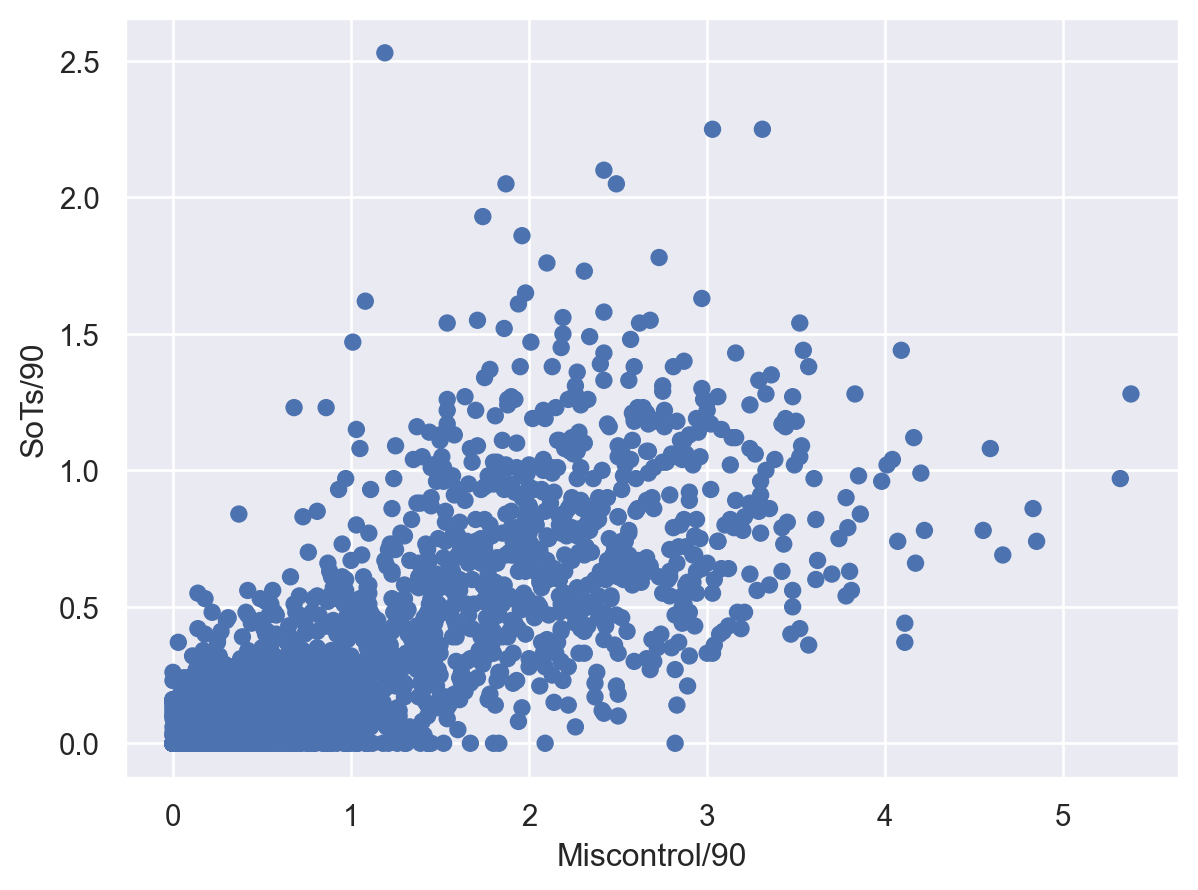

In [6]:
(
    so.Plot(data= data_procesada, x= "Miscontrol/90", y= "SoTs/90")
    .add(so.Dot())
)

(b) Escalar los datos y realizar un an´alisis de componentes principales, qued´andose solo con las dos primeras componentes. Realizar un gr´afico como el del punto anterior. ¿Cu´antos clusters puede distinguir en el gr´afico? ¿A qu´e caracter´ısticas de los jugadores pueden cor- responder los clusters? ¿C´omo pueden verificar su conjetura? (realizar una visualizaci´on o alg´un c´alculo)

In [7]:
X_star = StandardScaler().set_output(transform="pandas").fit_transform(data_num)
display(X_star)

,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,FKSht/90,np:G-xG,...,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,-0.348808,-0.740955,-0.702961,-0.549712,-0.421756,-0.544385,-0.214707,-0.195005,1.001348,-0.740595,...,-0.040374,0.809370,0.407232,0.231375,-0.521977,-0.324492,-0.116898,0.201795,0.584741,-0.295888
1,-0.821952,-0.146985,-0.514420,-0.922509,-0.497968,-0.762909,-0.690376,-0.557940,-0.396761,0.560360,...,0.678040,-0.874381,-1.084888,-0.705346,-0.935742,-0.714339,-0.006177,0.442418,0.868556,-0.986620
2,-0.821952,-0.740955,-0.938637,-1.046774,-0.269331,-0.599016,-0.193086,-0.428320,-0.396761,-1.130881,...,0.409434,-1.157826,-1.296369,-0.770699,-1.046752,-1.172982,-0.751696,-0.279450,0.915858,-1.058300
3,-0.821952,-0.278978,-0.608691,-0.673977,-0.497968,-0.653647,-0.484974,-0.583863,-0.396761,0.300169,...,-0.127778,-0.269415,-0.603180,-0.770699,-0.966017,-1.253244,-0.670501,-0.241852,0.800981,-0.866068
4,-0.538066,-0.740955,-0.797231,-0.673977,-0.650393,-0.762909,-0.917401,-0.972722,-0.396761,-0.350308,...,1.441221,-0.070580,-0.180217,-0.705346,-0.733905,-0.955126,0.517901,0.968780,0.888828,-0.830228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,-0.821952,0.182998,-0.278745,-1.046774,-0.193118,-0.599016,0.001507,-0.609787,-0.396761,0.820551,...,-0.477392,-0.172113,0.254495,0.144238,-0.209131,-0.141035,-0.943612,-1.174265,-1.131659,-0.152529
1955,0.975996,0.512982,0.899634,0.320147,0.797644,0.712126,1.104195,1.204886,-0.396761,-0.350308,...,0.846451,2.044685,0.971182,1.473076,1.022071,1.705004,1.049361,0.577768,-0.537001,1.632949
1956,0.786738,0.182998,0.522553,1.190006,-0.040693,0.438972,-0.084979,0.090158,-0.117140,0.430265,...,0.918932,1.511638,1.582129,1.625566,1.143173,2.026055,0.392418,-0.083944,-0.814058,1.616658
1957,1.165253,0.644975,1.041040,0.692944,0.035519,0.329710,0.390691,0.660484,0.255690,1.210838,...,0.070479,0.576691,0.266244,1.669134,1.778957,1.555945,-0.264525,-0.647903,-1.003267,0.945475


In [8]:
X_star_t = np.transpose(X_star)
N = len(X_star)
Sigma = (X_star_t @ X_star) / N

In [9]:
gamma, U = np.linalg.eigh(Sigma)
display(gamma)

array([4.10917697e-06, 1.19384488e-05, 1.68503260e-05, 1.82091972e-05,
       2.02487684e-05, 2.40907636e-05, 3.43707265e-05, 5.23759295e-05,
       1.45552476e-04, 2.73496900e-04, 2.93319291e-04, 3.16224853e-04,
       3.94106180e-04, 4.09537637e-04, 5.46877107e-04, 5.83266692e-04,
       7.16700188e-04, 1.04065022e-03, 1.55590731e-03, 1.80247999e-03,
       3.06746723e-03, 4.95295190e-03, 7.45159831e-03, 9.29492745e-03,
       1.10154991e-02, 1.62431538e-02, 1.76857972e-02, 2.13004985e-02,
       2.51154979e-02, 2.59919793e-02, 3.06787263e-02, 3.20720252e-02,
       3.53764267e-02, 3.63880385e-02, 3.85057542e-02, 4.37392341e-02,
       4.97491464e-02, 5.23010229e-02, 5.42893137e-02, 5.94265915e-02,
       6.38846305e-02, 7.47004582e-02, 7.66152585e-02, 7.75106015e-02,
       8.37275684e-02, 8.89886791e-02, 9.66821039e-02, 1.06898113e-01,
       1.09526695e-01, 1.19129273e-01, 1.20862547e-01, 1.33856623e-01,
       1.47032796e-01, 1.51821384e-01, 1.64938372e-01, 1.78954974e-01,
      

In [10]:
gamma_flip = np.flip(gamma)
U = np.flip(U, 1)
display(gamma_flip)

array([2.83548495e+01, 2.31482414e+01, 8.75805473e+00, 6.15050818e+00,
       3.38395968e+00, 2.98121630e+00, 2.33805761e+00, 1.85956741e+00,
       1.54042037e+00, 1.43743872e+00, 1.34121469e+00, 1.24763042e+00,
       1.18130292e+00, 1.08809404e+00, 9.87191708e-01, 9.05443792e-01,
       8.84525197e-01, 8.57245435e-01, 8.17578346e-01, 7.49063352e-01,
       7.02326888e-01, 6.64004607e-01, 6.27670271e-01, 6.01913328e-01,
       5.61094440e-01, 5.26055496e-01, 4.98750254e-01, 4.90334769e-01,
       4.80739457e-01, 4.55964370e-01, 4.28969639e-01, 4.08993626e-01,
       3.77182254e-01, 3.55064460e-01, 3.48007361e-01, 3.23806082e-01,
       3.12403741e-01, 3.11497765e-01, 3.06164931e-01, 2.92256492e-01,
       2.54868745e-01, 2.52268890e-01, 2.28670627e-01, 2.14380834e-01,
       2.00750949e-01, 1.97197554e-01, 1.89022332e-01, 1.78954974e-01,
       1.64938372e-01, 1.51821384e-01, 1.47032796e-01, 1.33856623e-01,
       1.20862547e-01, 1.19129273e-01, 1.09526695e-01, 1.06898113e-01,
      

In [11]:
Z = X_star @ U 
Z.columns = ["Z" + str(i) for i in range(1,104)]
Z

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,Z94,Z95,Z96,Z97,Z98,Z99,Z100,Z101,Z102,Z103
0,2.100549,3.102131,0.069721,3.466709,-1.534413,-0.797459,-0.964890,0.336628,-0.096172,1.580154,...,0.001673,-0.001527,0.002803,-0.010926,-0.005153,0.007145,-0.002475,0.000124,0.005729,0.000317
1,6.465888,0.659801,0.800572,-2.203138,-0.490958,-0.208674,1.894935,-0.589332,0.157025,1.902535,...,-0.007254,0.000631,0.000345,-0.005724,-0.002544,-0.000939,-0.005224,0.007384,-0.002488,0.001966
2,6.691318,-1.763479,0.122005,-1.303993,-0.183925,-1.517059,3.398102,0.809231,-0.312790,-0.248084,...,0.025622,0.001313,0.003715,-0.005236,-0.003408,0.008825,-0.000870,-0.000624,-0.001041,0.001867
3,4.978559,-0.332884,1.151559,-0.312502,-0.520630,-1.255471,-0.121850,0.486088,-0.163050,-0.655212,...,-0.019302,-0.002008,0.008340,0.005881,-0.006341,-0.003692,0.004895,0.001290,0.001443,0.002128
4,6.470083,3.510029,-1.107170,-1.185132,-1.105577,-0.739738,1.127987,0.422510,0.448894,1.904253,...,-0.008822,-0.005886,0.002162,0.001737,0.002262,0.001982,0.002466,0.003346,0.006255,0.000201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1954,-0.740380,-5.226160,2.914965,-1.230529,0.371143,1.352290,-0.568066,0.365326,0.877772,0.442681,...,0.000061,0.004767,0.003943,-0.004668,-0.006337,-0.001748,0.003597,0.002152,-0.001823,-0.002925
1955,-8.602390,4.539589,-0.760691,0.214197,0.860598,4.140731,2.463280,1.165792,-1.280857,-0.624496,...,-0.010804,-0.032717,0.005823,-0.005993,-0.003335,-0.000726,-0.002053,-0.001241,0.000139,0.000880
1956,-7.008049,-0.091112,-0.958479,0.608810,-1.457641,1.471182,1.273668,1.646302,-0.268907,-1.373984,...,0.027353,0.010731,0.001527,-0.006263,-0.002536,0.001330,-0.004086,0.012069,0.002713,-0.001429
1957,-6.413042,-2.174779,-0.240240,0.856560,-0.064357,2.846500,2.930223,0.409954,1.509664,0.169320,...,-0.014397,0.002242,-0.007691,0.001635,0.000327,-0.000679,0.001043,0.000976,-0.004975,-0.001740


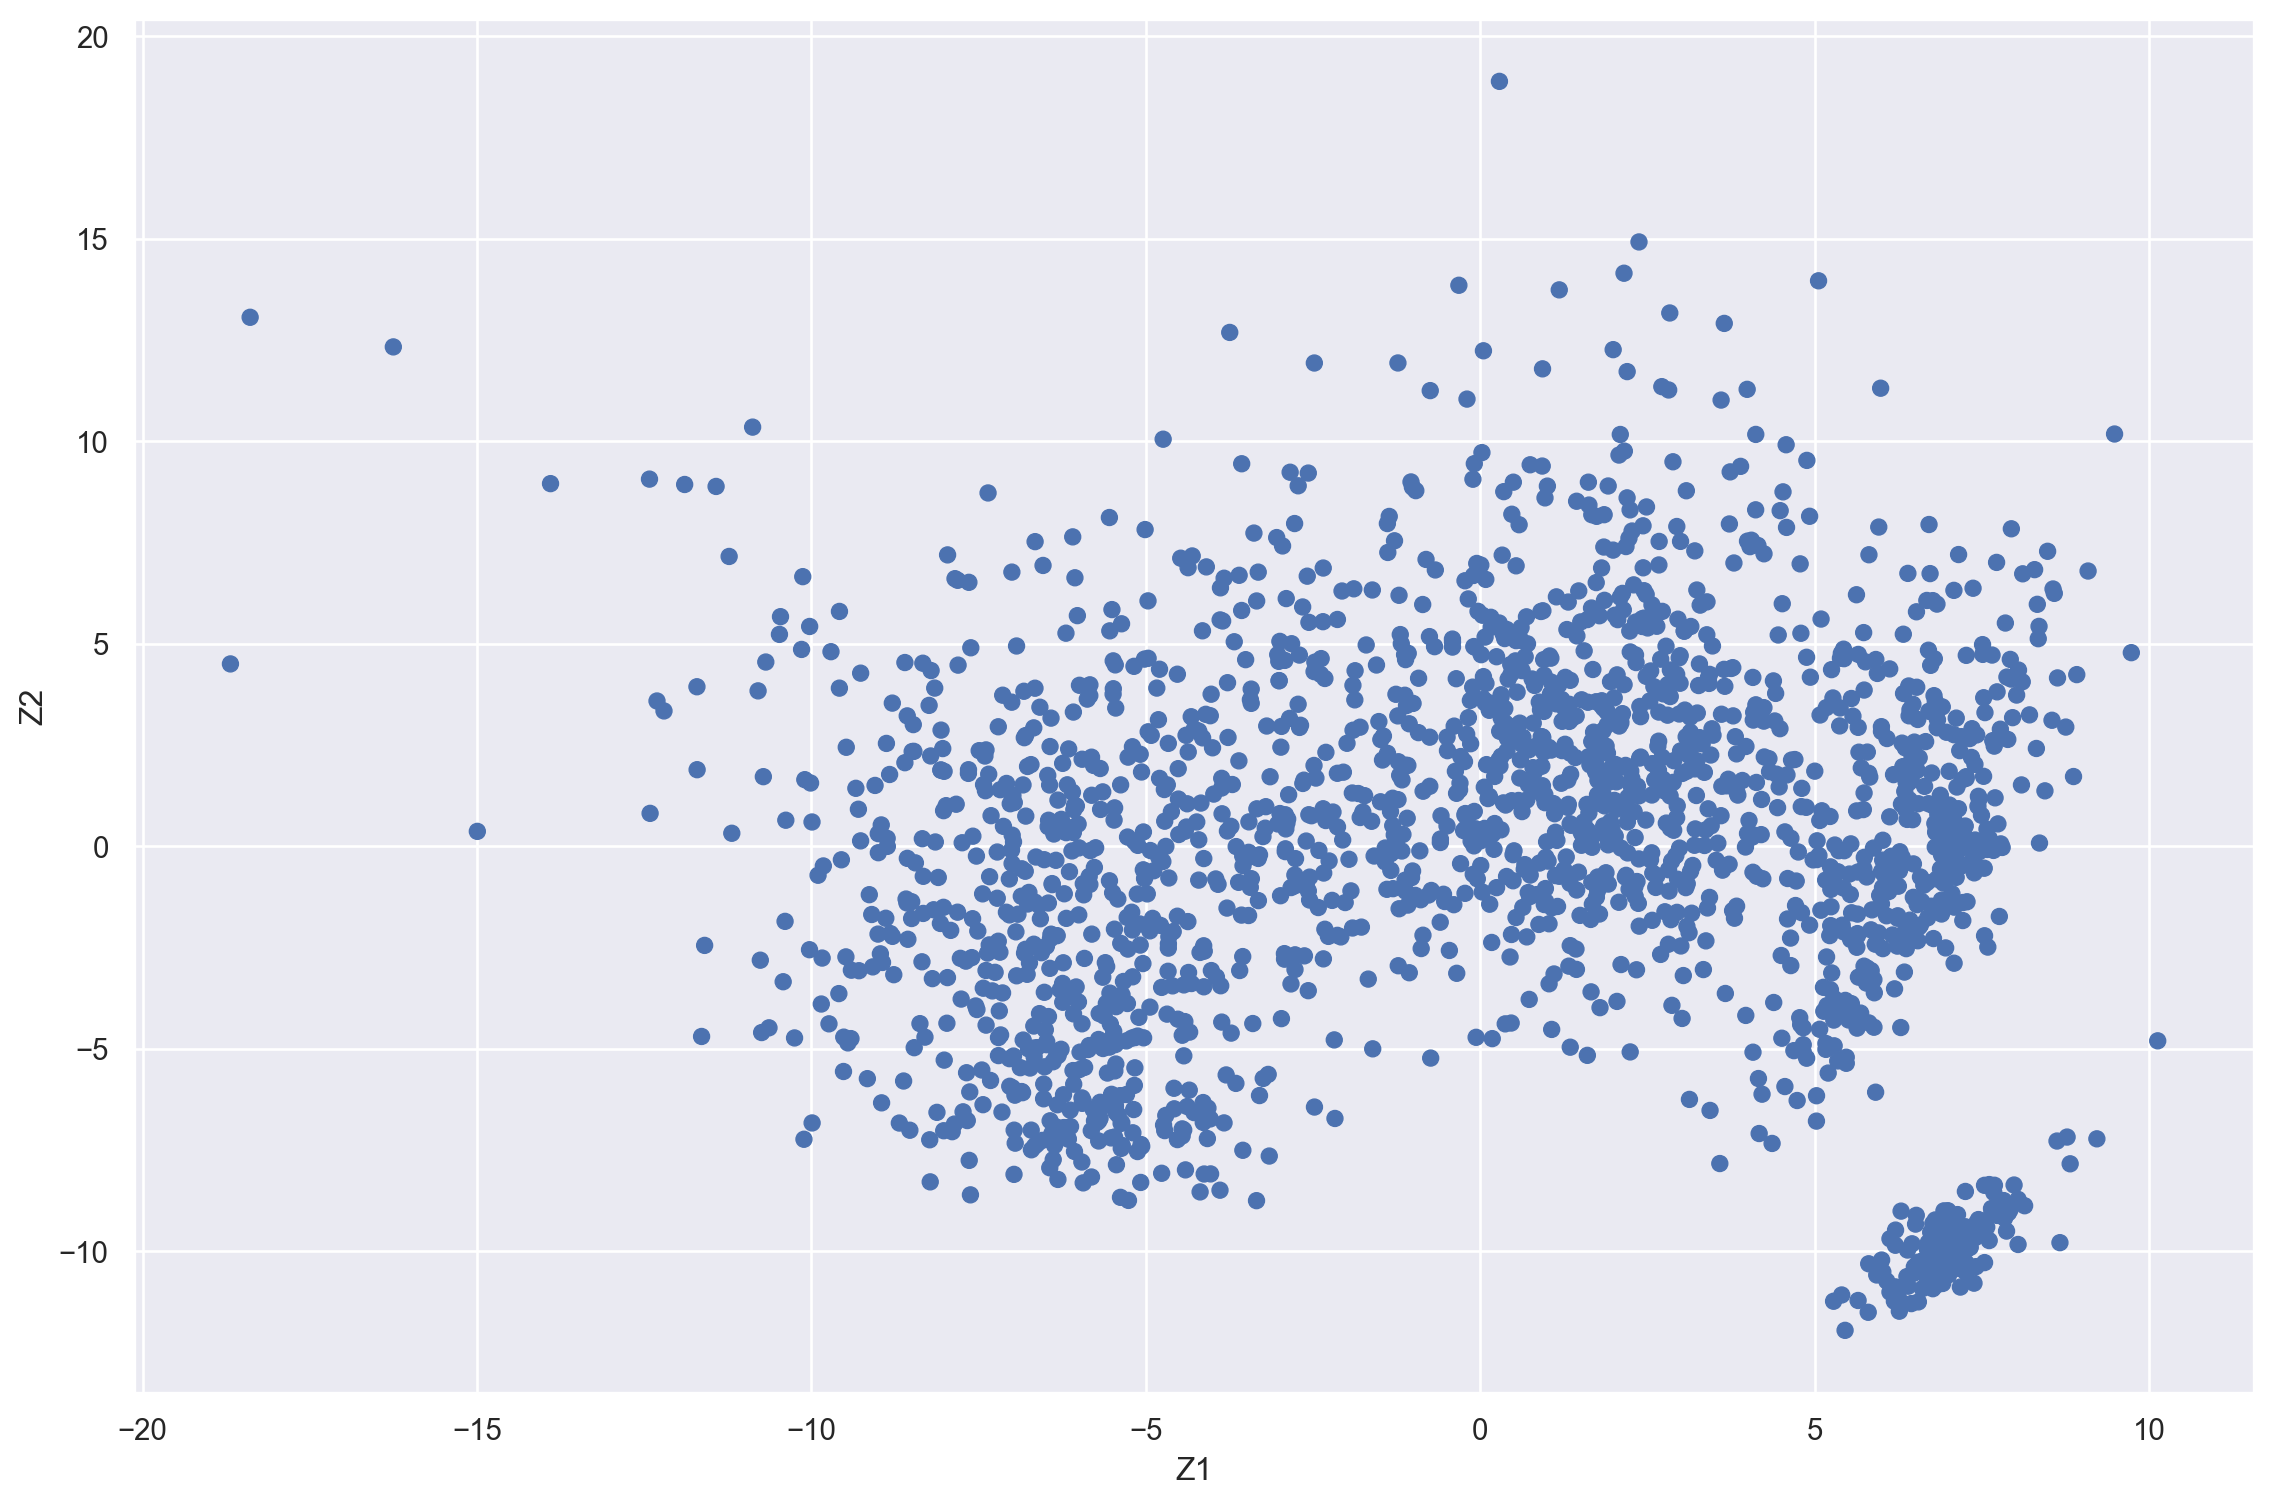

In [12]:
(
    so.Plot(data = Z, x = "Z1", y = "Z2")
    .add(so.Dot())
    .layout(size=(12,8))    
)

(c) Para la cantidad de clusters observados en el ´ıtem anterior, realizar un agrupamiento por k-medias, y colorear los puntos seg´un las etiquetas obtenidas. ¿Coinciden las etiquetas con lo esperado?

c:\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


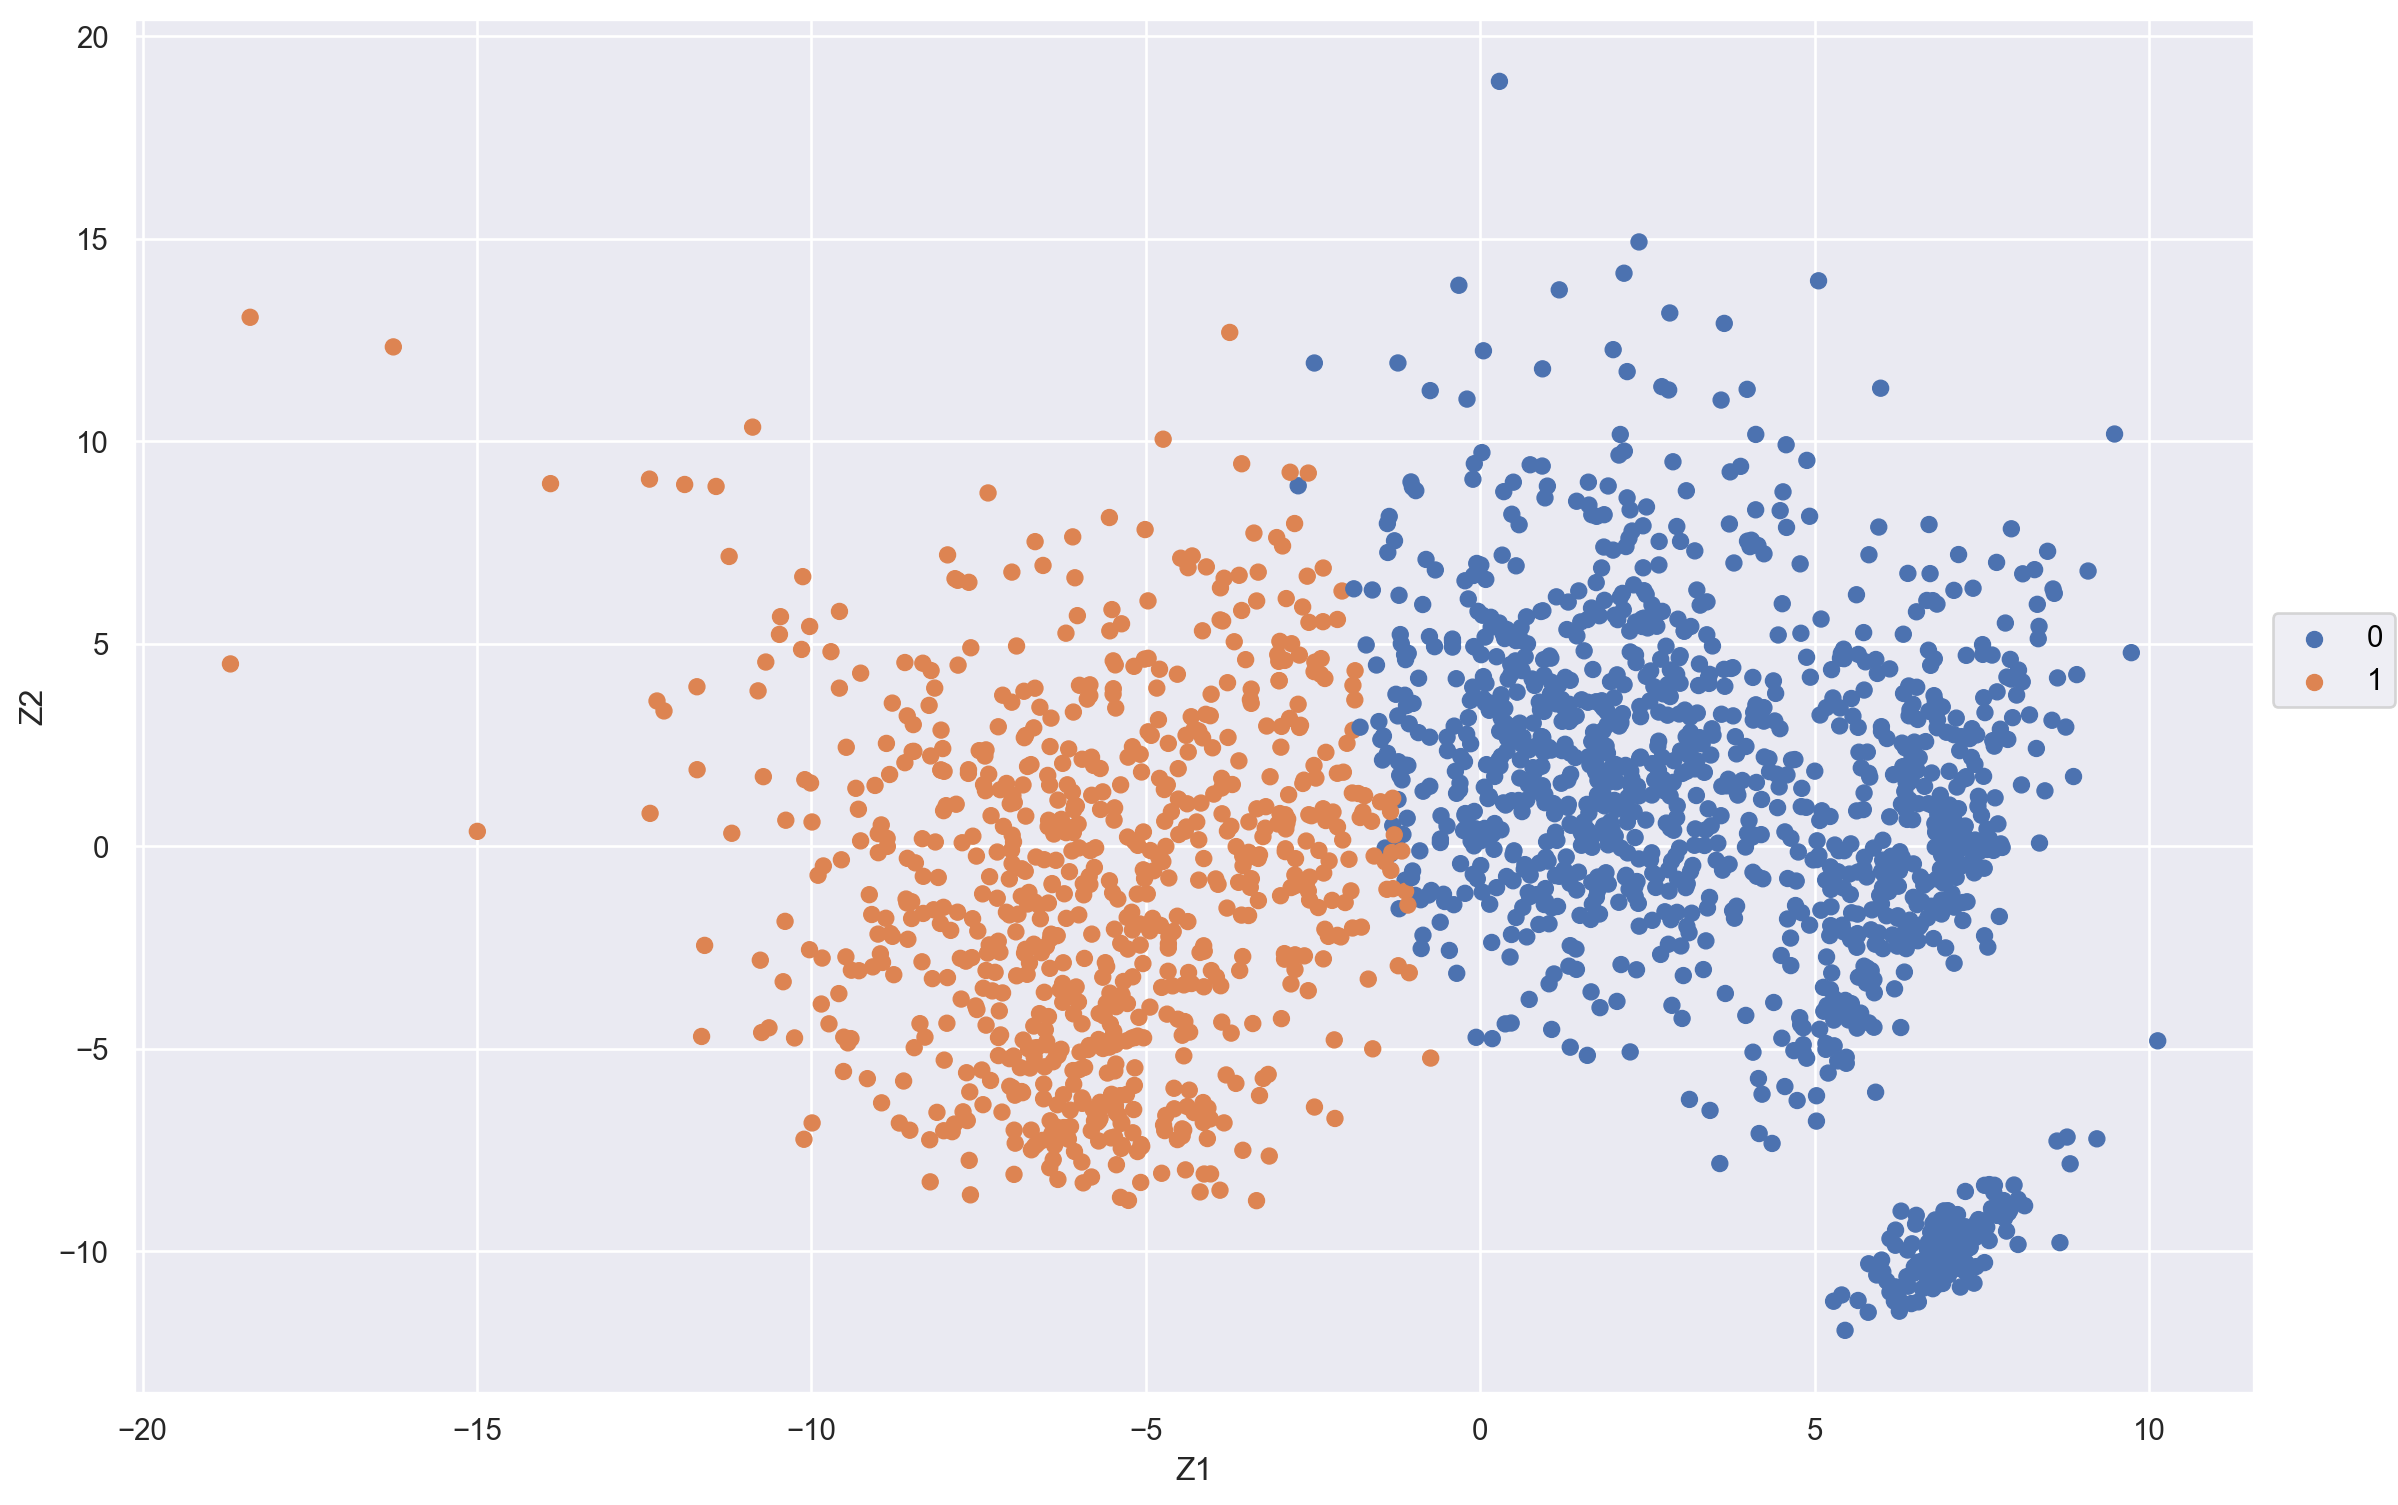

In [62]:
kmeans = KMeans (n_clusters = 2)

etiquetas = kmeans.fit_predict(Z).astype(str)

(
    so.Plot()
    .add(so.Dot(), data = Z, x = "Z1", y = "Z2", color = etiquetas)
    .layout(size=(12,8))
)

(d) Repetir el agrupamiento utilizando DBSCAN. ¿C´omo eligir´ıan en este caso un valor de ε apropiado?

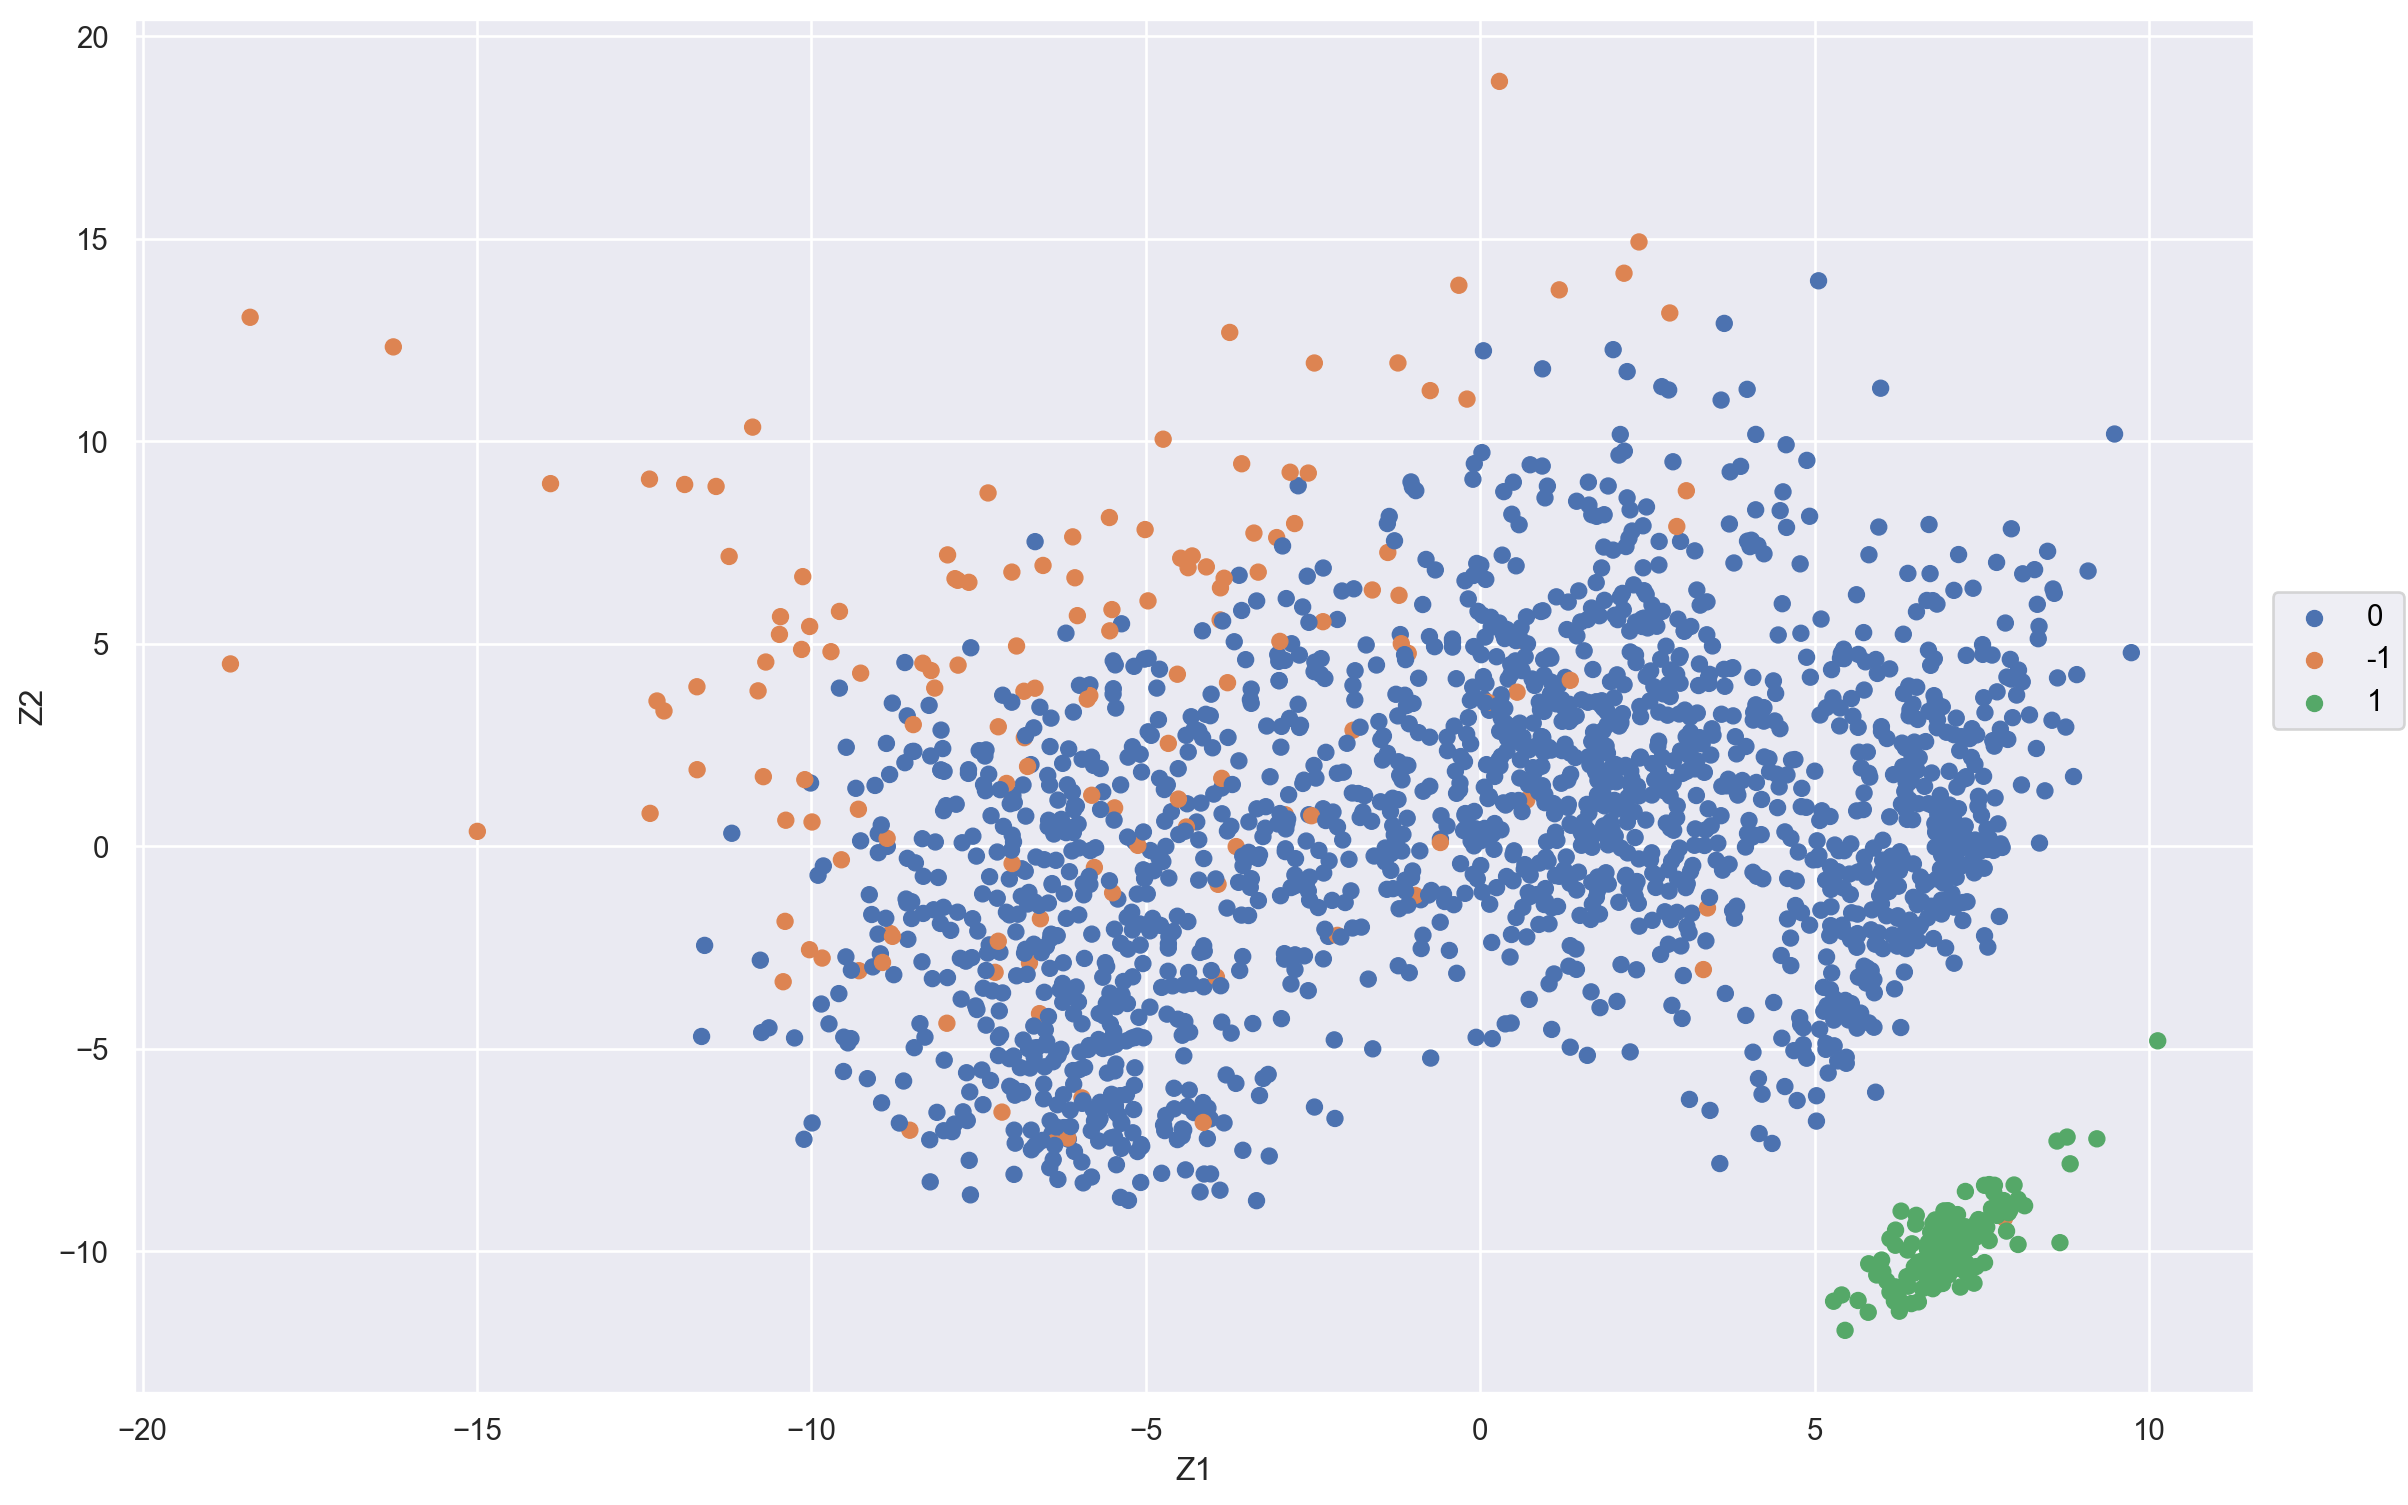

In [16]:
clustering = DBSCAN (eps= 8,min_samples = 2)

etiquetas = clustering.fit_predict(Z)

(
    so.Plot(data = Z, x = "Z1", y = "Z2", color = etiquetas.astype(str))
    .add(so.Dot())
    .layout(size=(12,8))
)

In [17]:
outliers = 0

for valor in etiquetas:
    if valor == -1:
        outliers += 1

outliers

146

e) Utilizar DBSCAN para realizar agrupamiento utilizando como datos todas las variables
originales en vez de solo las dos componentes principales, modificando los valores de
epsilon y minPts convenientemente. ¿Con cu´al de las dos opciones obtienen mejores
resultados?

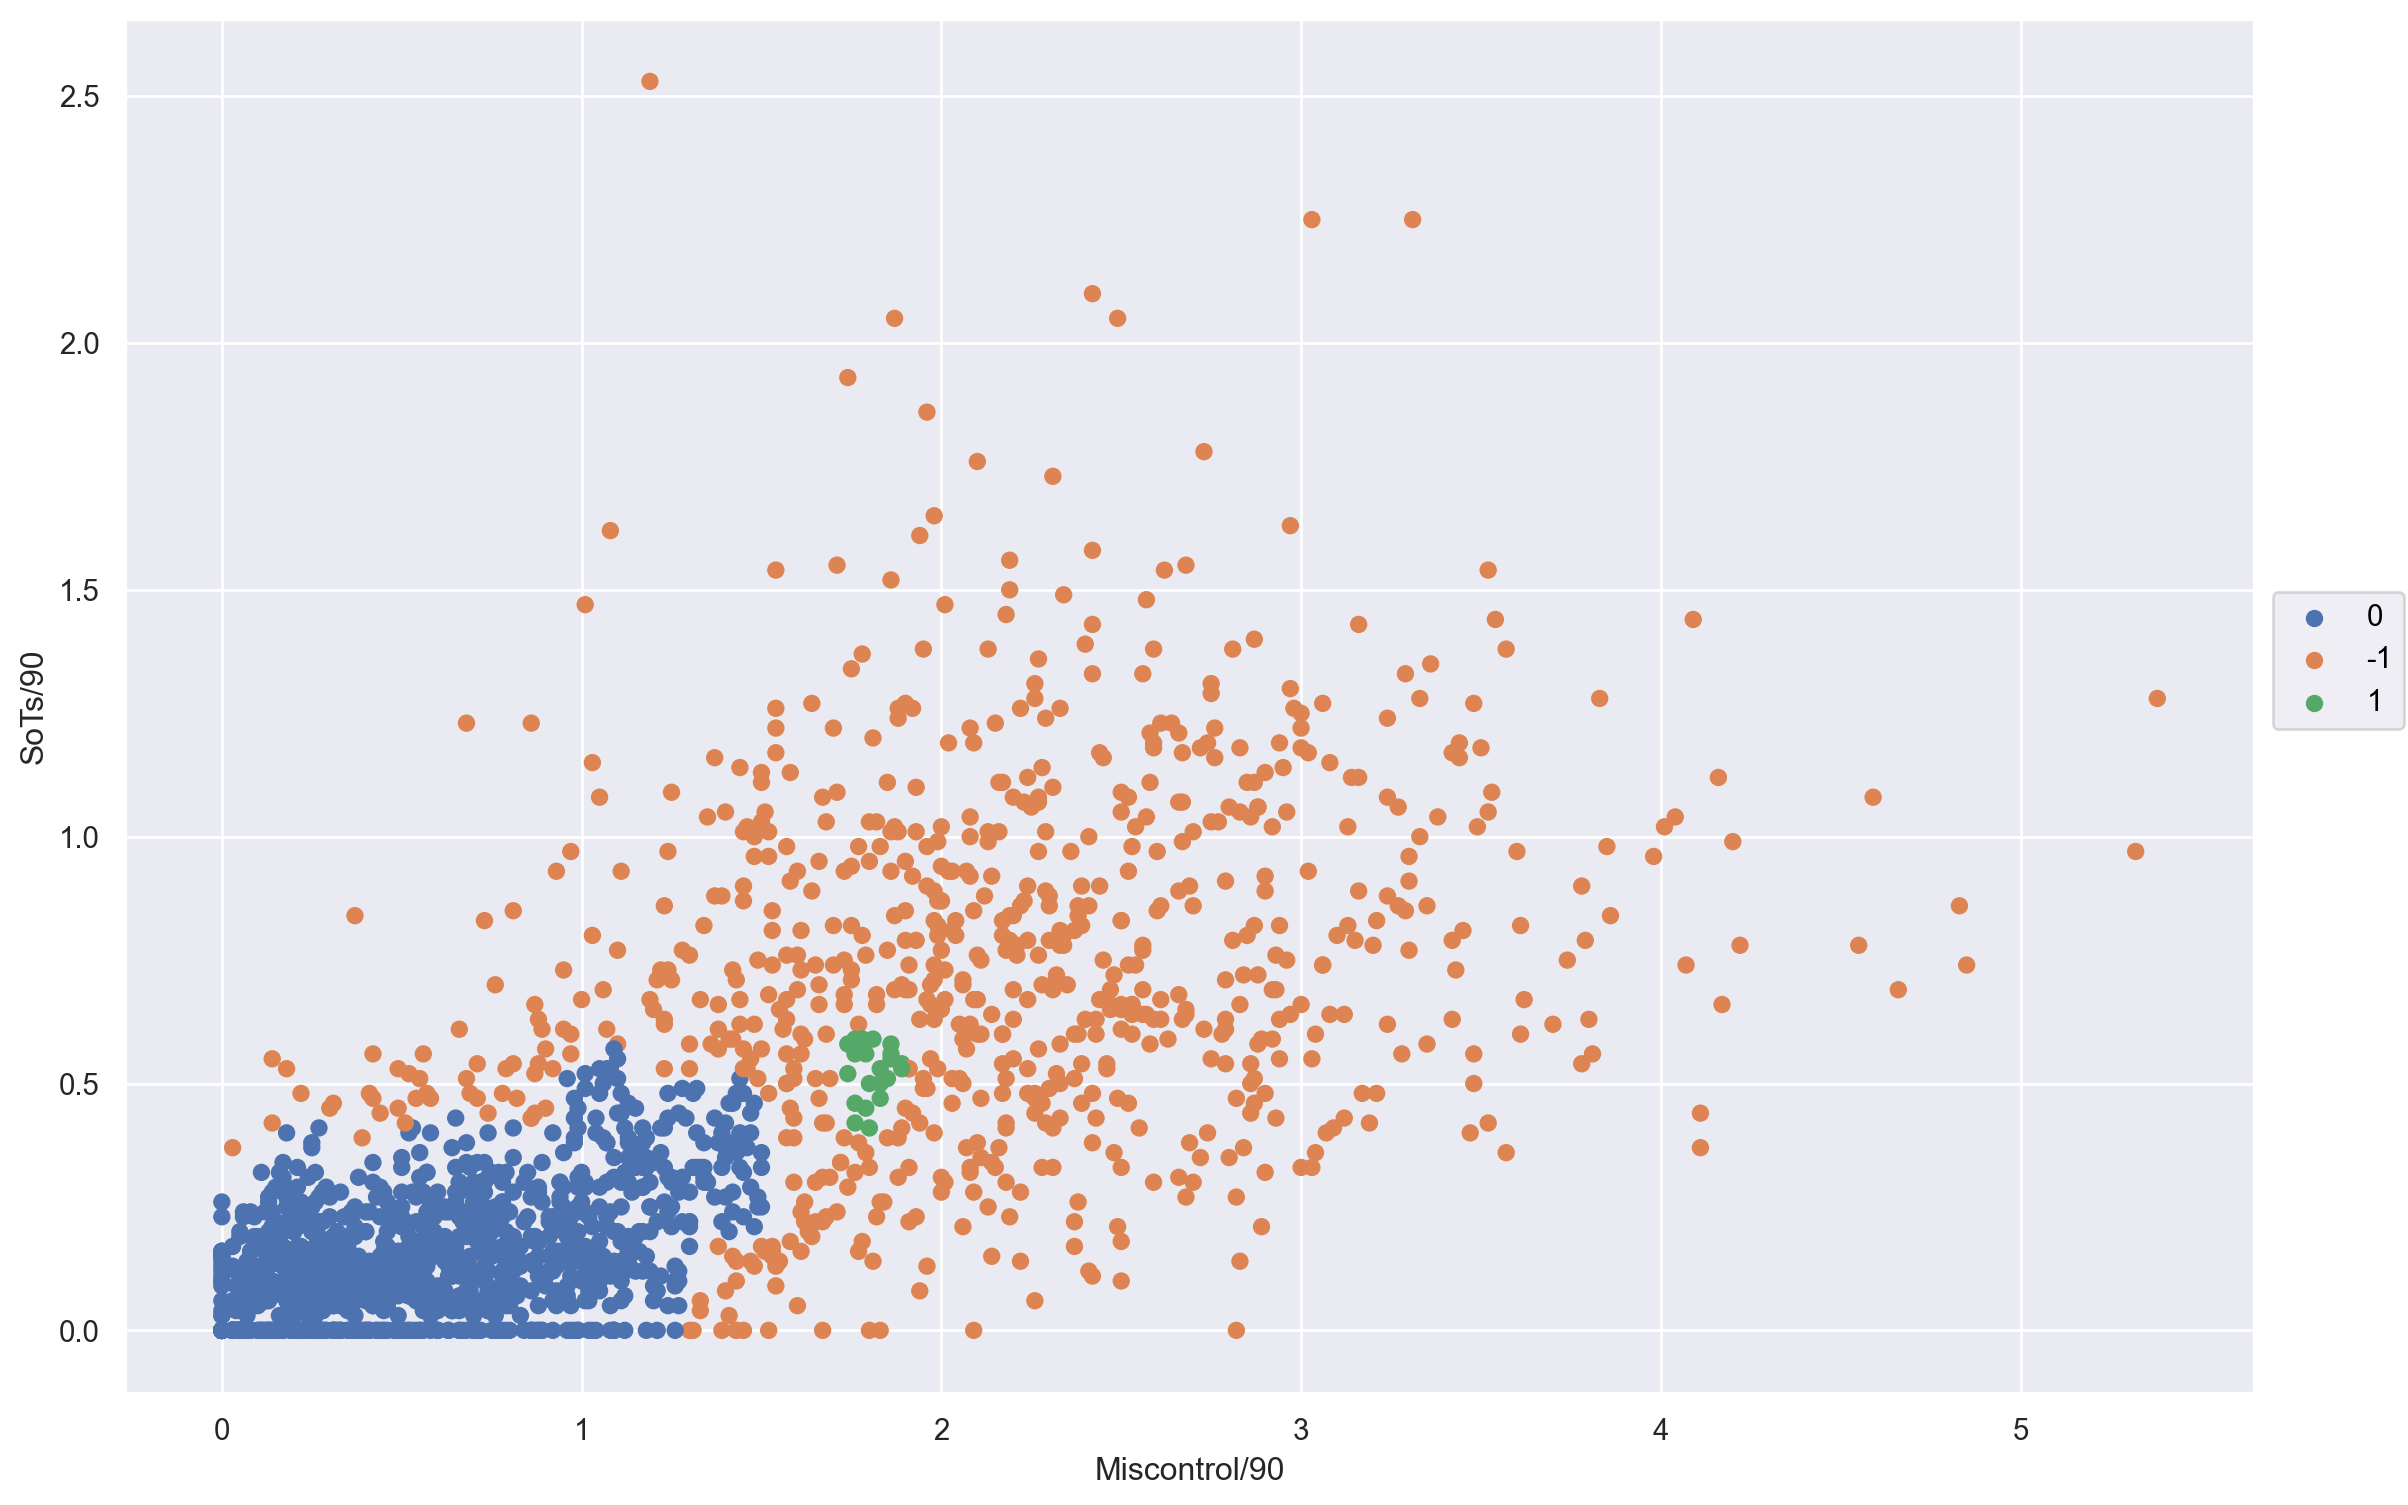

In [60]:
clustering2 = DBSCAN (eps= 0.1,min_samples = 23)

etiquetas = clustering2.fit_predict(data_procesada)
(
    so.Plot(data = data_procesada, x= "Miscontrol/90", y= "SoTs/90", color = etiquetas.astype(str))
    .add(so.Dot())
    .layout(size=(12,8))
)

In [61]:
outliers = 0

for valor in etiquetas:
    if valor == -1:
        outliers += 1

outliers

748

(Se observan los dos grupos pero los outliers son como 7 veces lo que con los PCA)

## Clasificación

In [18]:
data_clasif = data_proc.drop(columns = [col for col in data_proc.columns if data_proc[col].dtype not in ['float64','int64']])
data_clasif = data_clasif.drop(columns = data_num.columns.tolist()[:data_num.columns.tolist().index('Ast/90')]).join(data_proc['Pos'].apply(lambda x: x.split(',')[0])).rename(columns = {'Pos': 'Pos_filt'})

X_train, X_test, y_train, y_test = train_test_split(data_num, data_clasif['Pos_filt'], test_size=0.2, random_state=42)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)

Fitting 1567 folds for each of 19 candidates, totalling 29773 fits


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

### Componentes principales

In [19]:
data_comp_princ = Z.drop(columns= Z.columns.tolist()[2:])

X_train, X_test, y_train, y_test = train_test_split(data_comp_princ, data_clasif['Pos_filt'], test_size=0.2, random_state=42)

clsf = GridSearchCV(estimator = KNeighborsClassifier(),param_grid={'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}, cv = LeaveOneOut(), verbose=1)
clsf.fit(X_train,y_train)

Fitting 1567 folds for each of 19 candidates, totalling 29773 fits


GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20]},
             verbose=1)

In [20]:
model = KNeighborsClassifier(n_neighbors = 14)
model.fit(X_train,y_train)
score = model.score(X_test, y_test)
print(score)

0.7448979591836735
